In [1]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

# SemTorch
from semtorch import get_segmentation_learner

from pathlib import Path
import random

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [2]:
import torch
torch.cuda.set_device(3)

In [3]:
%matplotlib inline
import numpy as np



Function por stablishing the seed for reproducibility


In [4]:
number_of_the_seed = 2020

random.seed(number_of_the_seed)
set_seed(number_of_the_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
path = Path("dataset/")
path_images = path/"Images"
path_labels = path/"Labels"

test_name = "test"

Obtaining the label associated with an image, in the case of segmentation it is a mask

In [6]:
get_y_fn = lambda x: Path(str(x).replace("Images","Labels"))



Aux function for splitting between training and testing


In [7]:
def ParentSplitter(x):
    return Path(x).parent.name==test_name

Loading the codes of the different classes. All the datasets have the same codes.

In [8]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

In [9]:
codes

array(['Background', 'answer', 'question', 'header', 'other'],
      dtype='<U10')

Early Stopping parameters

In [10]:
monitor_training="valid_loss"
comp_training=np.less

monitor_evaluating="dice"
comp_evaluating=np.greater

patience=4

In [11]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    Flip,
    VerticalFlip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

In [12]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): 
        self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
    
transformPipeline=Compose([
                        Rotate(p=0.40,limit=10),GridDistortion(),ShiftScaleRotate(), ElasticTransform(),
                        OpticalDistortion()
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transformPipeline)

In [13]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        # Change 255 for 4
        #mask[mask==40]=2
        #mask[mask==20]=1
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

In [14]:
path_manual_img = path_images
path_manual_lbl = path_labels

dataset/Images/train/0012947358.png


<AxesSubplot:>

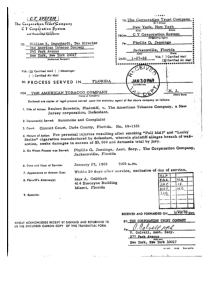

In [15]:
fnames_manual = get_image_files(path_manual_img)
lbl_names_manual = get_image_files(path_manual_lbl)

# open and show image
img_f = fnames_manual[20]
print(img_f)
img = PILImage.create(img_f)
img.show(figsize=(5, 5))

In [16]:
print(get_y_fn(img_f))

dataset/Labels/train/0012947358.png


<AxesSubplot:>

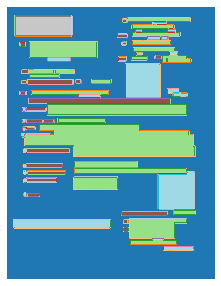

In [17]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [18]:
np.unique(np.array(mask))

array([0, 1, 2, 3, 4], dtype=uint8)

In [19]:
size = (1000,754)
bs = 2

In [20]:
codes

array(['Background', 'answer', 'question', 'header', 'other'],
      dtype='<U10')

In [21]:
def my_get_items(folders,path):
    return (get_image_files(path))

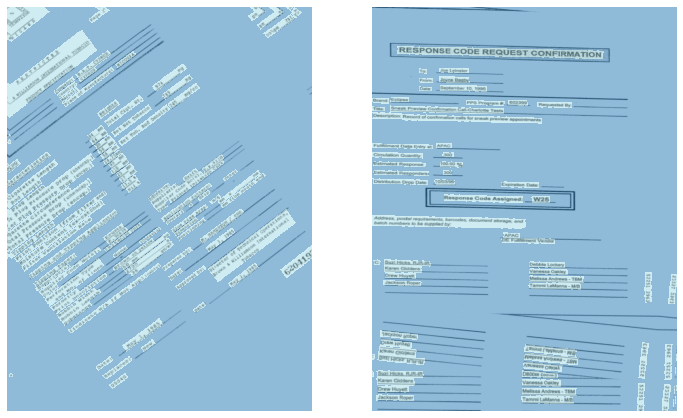

In [22]:
manual = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train']),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.1,seed=2020),
                   item_tfms=[Resize(size), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )
#manual.summary(path_images)
dls = manual.dataloaders(path_images,bs=bs)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

In [23]:
x,mask=dls.one_batch()

# HRNet

In [24]:
learn = get_segmentation_learner(dls=dls, number_classes=5, segmentation_type="Semantic Segmentation",
                                 architecture_name="hrnet", backbone_name="hrnet_w30", 
                                 metrics=[DiceMulti],wd=1e-2,
                                 pretrained=True,normalize=True).to_fp16()

In [25]:
# learn.lr_find() # find learning rate
# learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,dice_multi,time
0,0.825621,1.508930,0.283097,00:44
1,0.482480,0.978686,0.344262,00:45
2,0.361513,0.538493,0.445307,00:38
3,0.311311,0.443275,0.466794,00:39
4,0.294003,1.224142,0.225983,00:40
5,0.283148,0.387802,0.471384,00:40
6,0.285468,0.542289,0.425053,00:39
7,0.285078,0.519050,0.447189,00:40
8,0.277248,1.881043,0.266602,00:44
9,0.280253,0.380032,0.540444,00:40


/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Better model found at epoch 0 with valid_loss value: 1.5089296102523804.


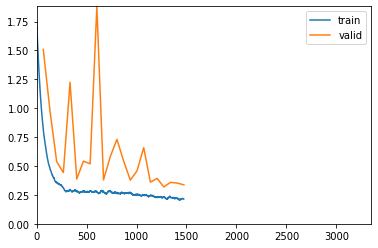

Better model found at epoch 1 with valid_loss value: 0.9786861538887024.
Better model found at epoch 2 with valid_loss value: 0.5384933352470398.
Better model found at epoch 3 with valid_loss value: 0.4432752728462219.
Better model found at epoch 5 with valid_loss value: 0.3878023326396942.
Better model found at epoch 9 with valid_loss value: 0.38003215193748474.
Better model found at epoch 13 with valid_loss value: 0.3778001368045807.
Better model found at epoch 16 with valid_loss value: 0.36024385690689087.
Better model found at epoch 18 with valid_loss value: 0.3186146914958954.
No improvement since epoch 18: early stopping


In [26]:
Image.fromarray(fname="hrnet-before-unfreeze"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(50, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [27]:
learn.load("hrnet-before-unfreeze")
learn.unfreeze()
#learn.lr_find() # find learning rate
#learn.recorder # plot learning rate graph

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


epoch,train_loss,valid_loss,dice_multi,time
0,0.207230,0.301477,0.611663,00:39
1,0.209997,0.296426,0.613800,00:39
2,0.215278,0.295108,0.613869,00:41
3,0.223794,0.295086,0.613607,00:43
4,0.210085,0.293534,0.613694,00:41
5,0.216010,0.293674,0.614117,00:40
6,0.221321,0.293757,0.613707,00:40
7,0.213818,0.292712,0.613668,00:39
8,0.215379,0.293140,0.613484,00:47
9,0.213986,0.293405,0.613946,00:40


Better model found at epoch 0 with valid_loss value: 0.3014771044254303.


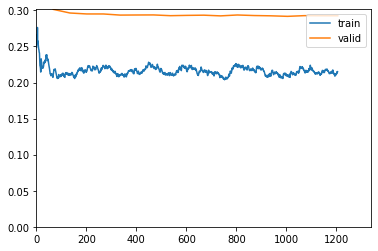

Better model found at epoch 1 with valid_loss value: 0.2964259088039398.
Better model found at epoch 2 with valid_loss value: 0.29510805010795593.
Better model found at epoch 3 with valid_loss value: 0.2950859069824219.
Better model found at epoch 4 with valid_loss value: 0.2935341000556946.
Better model found at epoch 7 with valid_loss value: 0.2927124500274658.
Better model found at epoch 10 with valid_loss value: 0.2924456298351288.
Better model found at epoch 14 with valid_loss value: 0.29179102182388306.
No improvement since epoch 14: early stopping


In [28]:
fname="hrnet-after-unfreeze"


callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(20, slice(1e-7,1e-7),cbs=callbacksFitAfterUnfreeze)

In [29]:
learn.validate()

(#2) [0.29179102182388306,0.6133673839974264]

In [30]:
aux=learn.model
aux=aux.cpu()

traced_cell=torch.jit.script(aux)
traced_cell.save("hrnet.pth")

In [31]:
def ParentSplitter(x):
    return Path(x).parent.name==test_name

In [32]:
dbtest = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train','test']),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize(size), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )
#manual.summary(path_images)
testDLS = dbtest.dataloaders(path_images,bs=bs)

In [33]:
learn.dls = testDLS

In [34]:
learn.validate()

(#2) [0.25137630105018616,0.6513740897562863]

In [4]:
import torchvision.transforms as transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

def transform_image(image):
    my_transforms = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(
                                            [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])])
    image_aux = image
    return my_transforms(image_aux).unsqueeze(0).to(device)

In [5]:
import PIL
import cv2
img = cv2.imread('dataset/Images/test/82092117.png')

In [6]:
img.shape

(1000, 754, 3)

In [7]:
img = Image.fromarray(img)
image = transforms.Resize((1000,754))(img)
tensor = transform_image(image=image)

In [8]:
model = torch.jit.load("hrnet.pth")
model = model.cpu()
model.eval()

RecursiveScriptModule(
  original_name=HRNet
  (backbone): RecursiveScriptModule(
    original_name=HighResolutionNet
    (conv1): RecursiveScriptModule(original_name=Conv2d)
    (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
    (conv2): RecursiveScriptModule(original_name=Conv2d)
    (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
    (relu): RecursiveScriptModule(original_name=ReLU)
    (layer1): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(
        original_name=Bottleneck
        (conv1): RecursiveScriptModule(original_name=Conv2d)
        (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
        (conv2): RecursiveScriptModule(original_name=Conv2d)
        (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
        (conv3): RecursiveScriptModule(original_name=Conv2d)
        (bn3): RecursiveScriptModule(original_name=BatchNorm2d)
        (relu): RecursiveScriptModule(original_name=ReLU)
        (downsample): Recu

In [9]:
model.to(device)
with torch.no_grad():
    outputs = model(tensor)

outputs = torch.argmax(outputs,1)

code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners

In [10]:
mask = np.array(outputs.cpu())


In [11]:
mask=np.reshape(mask,(1000,754))

In [14]:
img = Image.fromarray(mask.astype('uint8'))

In [18]:
img.save('test.png')

In [20]:
get_image_files('dataset/Images/test')

(#50) [Path('dataset/Images/test/93106788.png'),Path('dataset/Images/test/87093315_87093318.png'),Path('dataset/Images/test/86244113.png'),Path('dataset/Images/test/87137840.png'),Path('dataset/Images/test/82250337_0338.png'),Path('dataset/Images/test/82092117.png'),Path('dataset/Images/test/87594142_87594144.png'),Path('dataset/Images/test/87147607.png'),Path('dataset/Images/test/82252956_2958.png'),Path('dataset/Images/test/83635935.png')...]

In [22]:
for imPath in get_image_files('dataset/Images/test'):
    img = cv2.imread(str(imPath))
    img = Image.fromarray(img)
    image = transforms.Resize((1000,754))(img)
    tensor = transform_image(image=image)
    model.to(device)
    with torch.no_grad():
        outputs = model(tensor)

    outputs = torch.argmax(outputs,1)
    mask = np.array(outputs.cpu())
    mask=np.reshape(mask,(1000,754))
    img = Image.fromarray(mask.astype('uint8'))
    img.save('hrnetPreds/'+imPath.name)

code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners

code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners

code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners

code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners

code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners

code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners

code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners

code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners

code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners

code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners

code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners

code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners

code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners

code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners

code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners

code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners

code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
code/__torch__/torch/nn/functional/___torch_mangle_92.py:44: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners